In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, expon, gamma, erlang, ks_2samp
from fitter import Fitter, get_common_distributions
import numpy as np

# Service Times

In [ ]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2019-01-01']
df

In [ ]:
print("Median: ", df["Total Duration (min)"].median())
df["Total Duration (min)"].describe()

In [ ]:
df["Total Duration (min)"].hist(bins=50)

In [ ]:
df = df[df["Total Duration (min)"] < 1000]
df["Total Duration (min)"].hist(bins=50)

In [ ]:
rsv = df[df.Cluster == "BRYANT"]["Total Duration (min)"].values

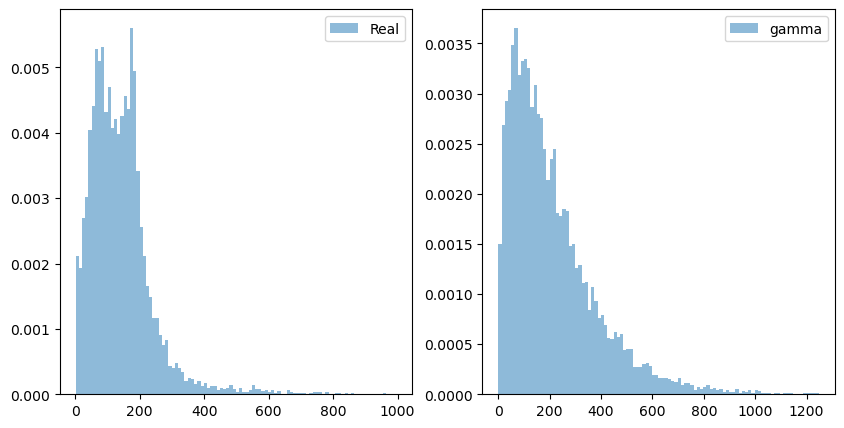

KstestResult(statistic=0.24120553359683794, pvalue=1.3288929354671917e-259, statistic_location=212.33333333333331, statistic_sign=1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# cdf = expon.rvs(size=len(rsv), scale=rsv.mean())
cdf = gamma.rvs(a=1.5, size=len(rsv), scale=rsv.mean())

axs[0].hist(rsv[rsv < 1250], bins=100, label="Real", alpha=0.5, density=True)
axs[0].legend()
axs[1].hist(cdf[cdf < 1250], bins=100, label="gamma", alpha=0.5, density=True)
axs[1].legend()
plt.show()
kstest(rsv, cdf)

Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 18.88it/s]


{'beta': {'a': 2.571517187137249,
  'b': 220660942909.3526,
  'loc': -9.68748437954443,
  'scale': 12971838592380.75}}

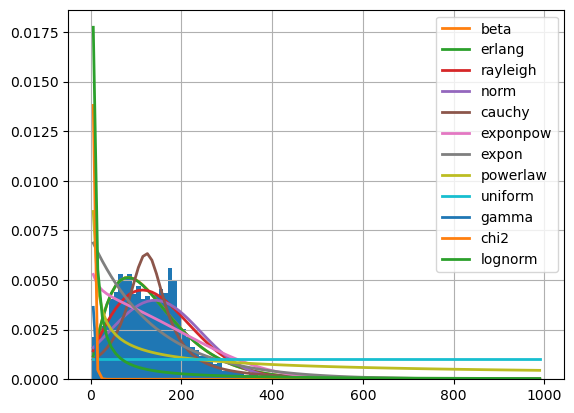

In [ ]:
f = Fitter(
    rsv, 
    timeout=10000, 
    distributions=get_common_distributions()  + ["erlang", "beta"],
    xmax=1000,
    )
f.fit(max_workers=8)
f.summary(Nbest=12)
f.get_best(method = 'sumsquare_error')


Exponential params FitParams(loc=0.851190747008161, scale=139.56775654222776)
Gamma params FitParams(a=2.0202296064552483, loc=0.0, scale=70.10521151029708)
Erlang params FitParams(a=2.0, loc=0.0, scale=70.8143885181706)


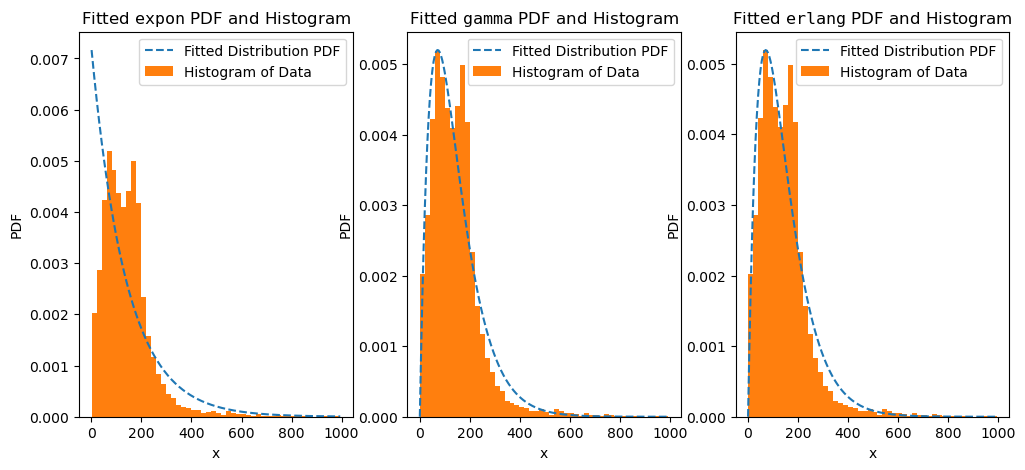

In [ ]:
from scipy.stats import fit 

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
# Exponential
bounds = [(0, 1000), (0, 1000)]
res_exp = fit(expon, rsv, bounds=bounds)
res_exp.plot(ax=axs[0])
print("Exponential params", res_exp.params)

# Gamma
bounds = [(0, 1000), (0, 1000), (0, 1000)]
res_gamma = fit(gamma, rsv, bounds=bounds)
res_gamma.plot(ax=axs[1])
print("Gamma params", res_gamma.params)

# Erlang 
bounds = [(0, 1000), (0, 1000), (0, 1000)]
res_erlang = fit(erlang, rsv, bounds=bounds)
res_erlang.plot(ax=axs[2])
print("Erlang params", res_erlang.params)


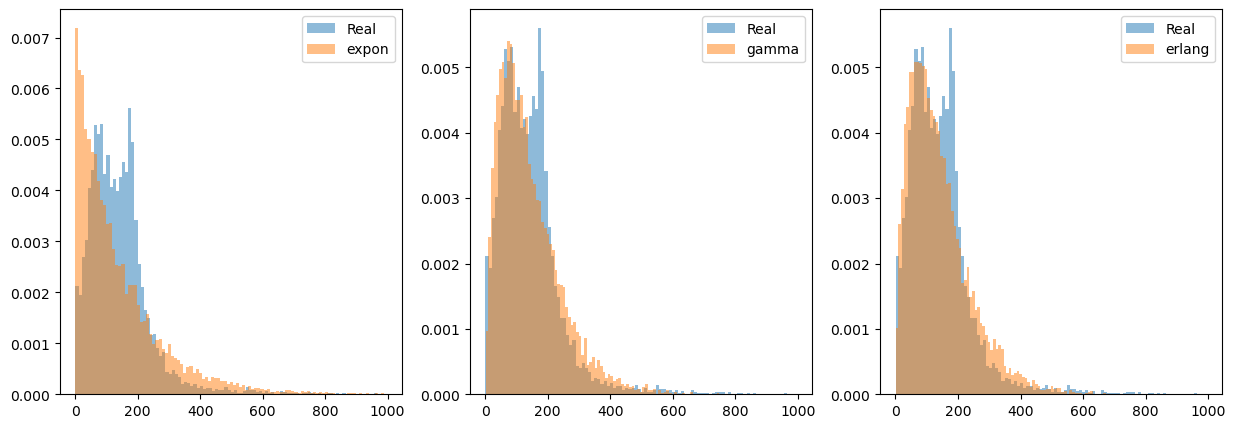

KstestResult(statistic=0.05464426877470352, pvalue=1.4236942566141945e-13, statistic_location=205.41666666666663, statistic_sign=1)
KstestResult(statistic=0.048616600790513886, pvalue=7.832277695489214e-11, statistic_location=220.9833333333333, statistic_sign=1)
KstestResult(statistic=0.1732213438735178, pvalue=3.0620482729472597e-133, statistic_location=56.84969411641733, statistic_sign=-1)


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# cdf = expon.rvs(size=len(rsv), scale=rsv.mean())
cdf_gamma = gamma.rvs(a=res_gamma.params.a, size=len(rsv), scale=res_gamma.params.scale)

axs[1].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[1].hist(cdf_gamma[cdf_gamma < 1000], bins=100, label="gamma", alpha=0.5, density=True)
axs[1].legend()
cdf_erlang = erlang.rvs(a=res_erlang.params.a, size=len(rsv), scale=res_erlang.params.scale)
axs[2].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[2].hist(cdf_erlang[cdf_erlang < 1000], bins=100, label="erlang", alpha=0.5, density=True)
axs[2].legend()

cdf_expon = expon.rvs(size=len(rsv), scale=res_exp.params.scale)
axs[0].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[0].hist(cdf_expon[cdf_expon < 1000], bins=100, label="expon", alpha=0.5, density=True)
axs[0].legend()
plt.show()
print(ks_2samp(rsv[rsv < 1000], cdf_gamma))
print(ks_2samp(rsv[rsv < 1000], cdf_erlang))
print(ks_2samp(rsv[rsv < 1000], cdf_expon))



# Distribution of number of sessions per time unit 

In [ ]:
df_sessions = pd.read_csv('../data/charging_session_count_1_to_30_censored_1.csv')
df_sessions = df_sessions[df_sessions['Period'] >= '2019-01-01']

In [ ]:
df_sessions['DayOfWeek'] = df_sessions['Period'].apply(lambda x: pd.to_datetime(x).dayofweek)
df_sessions['Time'] = df_sessions['Period'].apply(lambda x: pd.to_datetime(x).time())
df_sessions['Hour'] = df_sessions['Period'].apply(lambda x: pd.to_datetime(x).hour)
df_sessions.head()

In [13]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def plot_histogram(time, day_of_week):
    fig, axs = plt.subplots(figsize=(7, 5))
    time_specific_df = df_sessions[(df_sessions['DayOfWeek'] == day_of_week) & (df_sessions['Time'] == pd.to_datetime(time).time())]
    bins = range(0, int(time_specific_df['BRYANT_TRUE'].max()) + 2)
    axs.hist(time_specific_df['BRYANT_TRUE'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Session Count Distribution on {day_of_week_list[day_of_week]} {time}')
    plt.show()

time_intervals = [f'{hour:02d}:{minute:02d}' for hour in range(24) for minute in [0, 30]]
time_widget = widgets.SelectionSlider(
    options=time_intervals,
    value='08:00',
    description='Time:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram, time=time_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Time:', index=16, options=('00:00', '00:30', '01:00', '01:3…

<function __main__.plot_histogram(time, day_of_week)>

In [ ]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = df_sessions[(df_sessions['DayOfWeek'] == day_of_week) & (df_sessions['Hour'] == hour)]
    bins = range(0, int(time_specific_df['BRYANT_TRUE'].max()) + 2)
    axs.hist(time_specific_df['BRYANT_TRUE'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Session Count Distribution on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

In [ ]:
# Find first non-zero
df_sessions["BRYANT_TRUE"].hist(edgecolor='black', density=True)

In [ ]:
# Find first non-zero
df_sessions["BRYANT_TRUE"].hist(edgecolor='black', density=True)

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import poisson
import numpy as np

In [ ]:
# get poisson deviated random numbers
# data = np.random.poisson(2, 1000)
data = df_sessions["BRYANT_TRUE"].values
# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(df_sessions["BRYANT_TRUE"].max()+1) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data', edgecolor='black')

# calculate bin centers
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function, bin_centers, entries)
print(parameters)
# plot poisson-deviation with fitted parameter
x_plot = np.arange(0, data.max())

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters),
    marker='o', linestyle='',
    label='Poisson fit result $\lambda=%.2f$' % parameters[0],
)
plt.legend()
plt.show()

In [ ]:
kstest(data, poisson.cdf, args=(parameters,))

In [ ]:
parameters

### Plots for section Methodology > Descriptive analysis

In [ ]:
observed_values = ['BRYANT_TRUE','CAMBRIDGE_TRUE','HAMILTON_TRUE','HIGH_TRUE','MPL_TRUE','RINCONADA_TRUE','TED_TRUE','WEBSTER_TRUE']
df_true_sessions = df_sessions[['BRYANT_TRUE','CAMBRIDGE_TRUE','HAMILTON_TRUE','HIGH_TRUE','MPL_TRUE','RINCONADA_TRUE','TED_TRUE','WEBSTER_TRUE', 'DayOfWeek', 'Hour', 'Period']]
df_hourly_sessions = df_true_sessions.groupby('Hour').median().reset_index(drop = False)
df_week_hourly_sessions = df_true_sessions.groupby('DayOfWeek', 'Hour').median().reset_index(drop = False)

In [ ]:
df_hourly_sessions[observed_values].plot()